# Homework 1

- Last name: 
- First Name:

Homework must be sent to `pwinant@escp.eu` by email before May 5th.

You are welcome to install any library, take any initiative you deem appropriate and encourage to help each other (but not copy/paste code).

---
## Exercise 1: Linear Regression

1. __For $N=100$, compute a sample $(x_i, y_i)_{i=[1:N]}$ satisfying $$y_i=0.4+2.5 x_i + \epsilon_i$$ where $x_i$ uniformly distributed between 0 and 1 and $\epsilon_i$ is drawn from a normal distribution with standard deviation 0.5.__

2. __Define the model $f(x;a,b)=a+b x$. Find the parameters $a$ and $b$ which minimize the objective $\xi(a,b)=\sum_i (f(x_i;a,b)-y_i)^2$ by using a numerical optimization algorithm (not the formula for the regression). Plot.__

<mark>Hint</mark>: you can write your own gradient descent algorithm or use an optimization library).

---

## Exercise 2: constrained optimization

Consider the function $f(x,y) = 1-(x-0.5)^2 -(y-0.3)^2$.

__Use Optim.jl to minimize $f$ without constraint. Check you understand diagnostic information returned by the optimizer.__

In [2]:
f(x,y) = 1-(x-0.5)^2 - (y-0.3)^2

f (generic function with 1 method)

In [5]:
f(v) = f(v...)   # or f(v) = f(v[1], v[2])

f (generic function with 2 methods)

In [6]:
f([0., 0.1])

0.71

In [7]:
using Optim

┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1423


In [8]:
maximize(f, [0.0, 0.0])   # minimize( u->-f(u) )

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [0.0,0.0]
 * Maximizer: [0.5000172833186103,0.2999408484491455]
 * Maximum: 1.000000e+00
 * Iterations: 34
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 66

__Now, consider the constraint $x<0.3$ and maximize $f$ under this new constraint.__

In [13]:
x0 = [0.0, 0.0]

2-element Vector{Float64}:
 0.0
 0.0

In [15]:
sol = optimize(u->-f(u), [-Inf, -Inf], [0.3, Inf], x0)

 * Status: success

 * Candidate solution
    Final objective value:     -9.600000e-01

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 1.20e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.83e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.20e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    3
    f(x) calls:    56
    ∇f(x) calls:   56


In [21]:
sol.g_converged

true

__Reformulate the problem as a root finding with lagrangians. Write the complementarity conditions.__

fun (generic function with 2 methods)

__Solve using NLsolve.jl__

In [1]:
using NLsolve

┌ Info: Precompiling NLsolve [2774e3e8-f4cf-5e23-947b-6d7e65073b56]
└ @ Base loading.jl:1423


In [34]:
fun(x, y, λ) = [
    - 2x + 1 - λ,
    -2y + 0.6,
    0.3 - x    #   \lambda \geq 0
]
fun(v) = fun(v...)

fun (generic function with 2 methods)

In [35]:
function fun!(F, v) 
    F[:] = fun(v)
end

fun! (generic function with 1 method)

In [37]:
# lower boundas:
a = [-Inf, -Inf, 0]
b = [Inf, Inf , Inf]

3-element Vector{Float64}:
 Inf
 Inf
 Inf

In [40]:
sol = mcpsolve(fun!, a, b, [0.0, 0.0, 0.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0, 0.0]
 * Zero: [0.30000000016911516, 0.3, 0.3999999996617697]
 * Inf-norm of residuals: 0.000000
 * Iterations: 5
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 6
 * Jacobian Calls (df/dx): 6

In [41]:
converged(sol)

true

In [42]:
sol.zero


3-element Vector{Float64}:
 0.30000000016911516
 0.3
 0.3999999996617697

---

## Exercise 3: Learning simple decision rules in the Consumption-Savings model

𝑟This exercise is inspired from *Individual learning about consumption* by Todd Allen and Chris Carroll [link](https://www.econstor.eu/bitstream/10419/72016/1/328292125.pdf).


We consider the following consumption saving problem. An agent receives random income $y_t = \exp(\epsilon_t)$ where $\epsilon_t\sim \mathcal{N}(\sigma)$ ($\sigma$ is the standard deviation.)

Consumer starts the period with available income $w_t$. The law of motion for available income is:

$$w_t = \exp(\epsilon_t) + (w_{t-1}-c_{t-1}) r$$

where consumption $c_t \in ]0,w_t]$ is chosen in each period in order to maximize:

$$E_t \sum_{t=0}^T \beta^t U(c_t)$$

given initial available income $w_0$.

In the questions below, we will use the following calibration:
- $\beta = 0.9$
- $\sigma = 0.1$
- $T=100$
- $U(x) = \frac{x^{1-\gamma}}{1-\gamma}$ with $\gamma=2$
- $w_0 = 1.1$ (alternatively, consider values 0.5 and 1)

The theoretical solution to this problem is a concave function $\varphi$ such that $\varphi(x)\in ]0,x]$ and $\forall t,  c_t=\varphi(w_t)$. Qualitatively, agents accumulate savings, up to a certain point (a buffer stock), beyond which wealth is not increasing any more (in expectation).

Carroll and Allen have noticed that the true solution can be approximated very well by a simple rule:

$\psi(x) = \min(x, \theta_0 + \theta_1 (x - \theta_0) )$

The main question they ask in the aforementioned paper is whether it is realistic that agents would learn good values of $\theta_0$ and $\theta_1$ by observing past experiences.

We would like to examine this result.

### Lifetime reward

__Define a NamedTuple to hold the parameter values__

In [155]:
p = (
   β  = 0.9,
    σ = 0.1,
    γ = 2.0,
    T = 100,
    w0 = 1.1,
    r = 1.01
)

(β = 0.9, σ = 0.1, γ = 2.0, T = 100, w0 = 1.1, r = 1.01)

__Define simple rule fonction `consumption(w::Number, θ_0::Number, θ_1::Number, p::NamedTuple)`
which compute consumption using a simple rule. What is the meaning of $\theta_0$ and $\theta_1$? Make a plot in the space $w,c$, including consumption rule and the line where $w_{t+1} = w_t$.__

(remark for later: `Number` type is compatible with ForwardDiff.jl 😉)

In [46]:
consumption(w, θ_0, θ_1, p) = min(w, θ_0 + θ_1*(w-θ_0))

consumption (generic function with 1 method)

In [47]:
using Plots

In [62]:
θ = [0.9, 0.08]

2-element Vector{Float64}:
 0.9
 0.08

In [63]:
wvec = range(0,5; length=1000);
cvec = [consumption(w, θ[1], θ[2], p ) for w in wvec];

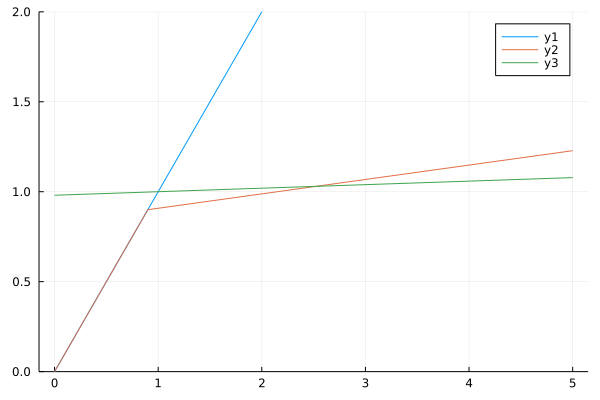

In [64]:
plot(wvec, wvec, ylims=(0,2))
plot!(wvec, cvec)
plot!(wvec, wvec.*(1-1/p.r).+1.0/p.r)

__Write a function `lifetime_reward(w_0::Number, θ_0::Number, θ_1::Number, p::NamedTuple)` which computes one realization of $\sum \beta^t U(c_t)$ for initial wealth `w_0` and simple rule `θ_0`, `θ_1`. Mathematically, we denote it by $\xi(\omega; \theta_0, \theta_1)$, where $\omega$ represents the succession of random income draws.__

In [69]:
using Statistics

In [71]:
std([randn() for i=1:1000000])

0.9997369999124471

In [109]:
function lifetime_reward(w_0, θ_0, θ_1, p; T=p.T, return_sim=false)
    V = 0.0
    δ = 1.0
    return_sim ? sim = [] : nothing
    for t=1:T
        c_0 = consumption(w_0, θ_0, θ_1, p)
        return_sim ? push!(sim, (;w=w_0, c=c_0)) : nothing
        ϵ = randn()*p.σ
        w_1 = (w_0 - c_0)*p.r + exp(ϵ)
        w_0 = w_1
        U_0 = c_0^(1-p.γ)/(1-p.γ)
        
        V += δ*U_0
        δ *= p.β
    end
    if !return_sim
        return V
    else
        return V, sim
    end
end

lifetime_reward (generic function with 1 method)

In [90]:
V, sim1 = lifetime_reward(p.w0, 0.8, 0.3, p; return_sim=true)
V, sim2 = lifetime_reward(p.w0, 0.8, 0.3, p; return_sim=true)
V, sim3 = lifetime_reward(p.w0, 0.8, 0.3, p; return_sim=true)

(-10.187777719695024, Any[(w = 1.1, c = 0.89), (w = 1.2450233716706482, c = 0.9335070115011945), (w = 1.2811353979723168, c = 0.944340619391695), (w = 1.4866950013176603, c = 1.006008500395298), (w = 1.463969302107319, c = 0.9991907906321957), (w = 1.5937254959244673, c = 1.0381176487773403), (w = 1.5173469226555065, c = 1.015204076796652), (w = 1.316035840396221, c = 0.9548107521188662), (w = 1.490743851355116, c = 1.0072231554065347), (w = 1.461791393568053, c = 0.998537418070416)  …  (w = 1.8546729699073947, c = 1.1164018909722184), (w = 1.7302986880169158, c = 1.0790896064050748), (w = 1.8025997525069983, c = 1.1007799257520996), (w = 1.724397215041446, c = 1.0773191645124338), (w = 1.7415138182102106, c = 1.0824541454630632), (w = 1.8519190234408986, c = 1.1155757070322696), (w = 1.747006365205586, c = 1.0841019095616757), (w = 1.766651537813773, c = 1.0899954613441318), (w = 1.5690663218272234, c = 1.030719896548167), (w = 1.522368051910922, c = 1.0167104155732767)])

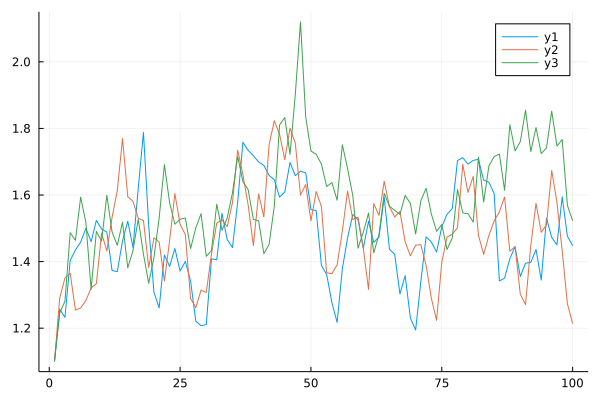

In [91]:
plot([e.w for e in sim1])
plot!([e.w for e in sim2])
plot!([e.w for e in sim3])

__Write a function `expected_lifetime_reward(w_0::Number, θ_0::Number, θ_1::Number,  p::NamedTuple; N=1000)` which computes expected lifetime reward using `N` Monte-Carlo draws. Mathematically, we write it $\Xi^{N}(\theta_0, \theta_1) =\frac{1}{N} \sum_1^N {\xi(\omega_N; \theta_0, \theta_1)}$. Check empirically that standard deviation of these draws decrease proportionally to $\frac{1}{\sqrt{N}}$ .__

In [106]:
expected_lifetime_reward(w_0, θ_0, θ_1, p; N=1000) = 
sum( lifetime_reward(w_0, θ_0, θ_1, p) for it in 1:N )/ N

expected_lifetime_reward (generic function with 1 method)

In [111]:
@time expected_lifetime_reward(p.w0, 0.8, 0.3, p; N=100000)

  0.199967 seconds (3 allocations: 96 bytes)


-10.237567261278564

In [124]:
Nvec = [10, 100, 1000, 10000]
values = [expected_lifetime_reward(p.w0, 0.8, 0.3, p; N=n) for n in Nvec]

4-element Vector{Float64}:
 -10.272434542180445
 -10.261876137182862
 -10.236602350305729
 -10.237722904406546

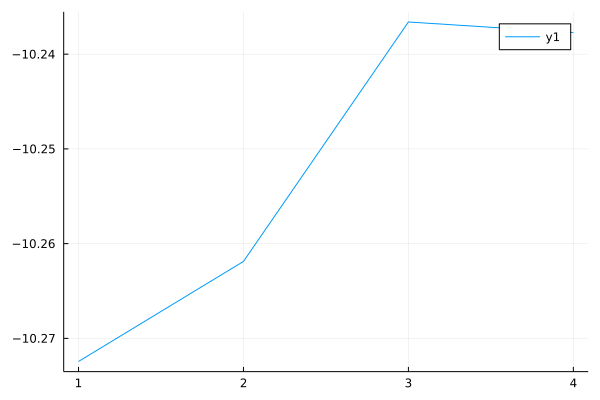

In [125]:
plot(values)

In [126]:
K = 1000
N = 1000
function compute_statistics(K,N)
    values = [expected_lifetime_reward(p.w0, 0.8, 0.3, p; N=N) for k = 1:K]
    mean(values) , std(values)
end

compute_statistics (generic function with 1 method)

In [127]:
std_values = [compute_statistics(K, n) for n in Nvec]

4-element Vector{Tuple{Float64, Float64}}:
 (-10.238950545868379, 0.05457789637520804)
 (-10.236629317827548, 0.018625280596690646)
 (-10.236981077681534, 0.005555522105185848)
 (-10.237227458930144, 0.0017865162556239596)

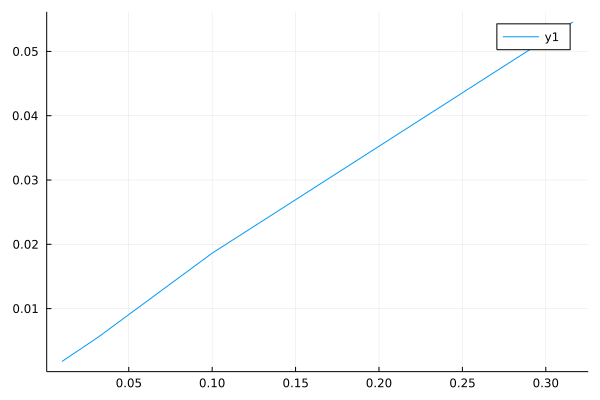

In [133]:
plot(1 ./sqrt.(Nvec), [e[2] for e in std_values])

__Using a high enough number for `N`, compute optimal values for $\theta_0$ and $\theta_1$. What is the matching value for the objective function converted into an equivalent stream of determinstic consumption ? That is if `V` is the approximated value computed above, what is $\bar{c}\in \R$ such that $ V= \sum_{t=0}^T \beta^t U(\bar{c})$ ?__


In [145]:
fun(θ_0, θ_1) = expected_lifetime_reward(p.w0, θ_0, θ_1, p; N=100000)
fun(v) = fun(v...)

fun (generic function with 3 methods)

In [146]:
using Optim

In [147]:
sol = maximize(fun, [1.0, 0.1])

LoadError: InterruptException:

In [144]:
sol

LoadError: type MaximizationWrapper has no field zero

__Using a high enough number for `N`, make contour plots of lifetime rewards as a function of `θ_0` and `θ_1`. Ideally, represent lines with $1\%$ consumption loss, $5\%$ and $10\%$ deterministic consumption loss w.r.t. to maximum.__

In [158]:
θ_0_vec = range(0.8, 1.2; length=10)
θ_1_vec = range(0, 0.1; length=10)
values = [fun(x,y) for x in θ_0_vec, y in θ_1_vec]



10×10 Matrix{Float64}:
 -12.4997   -12.1497   -11.8836   …  -11.1183   -11.0242   -10.9405
 -11.8418   -11.5896   -11.3945      -10.8233   -10.7526   -10.6901
 -11.2497   -11.0798   -10.946       -10.5475   -10.4975   -10.4538
 -10.7153   -10.6146   -10.5345      -10.2919   -10.26     -10.234
 -10.2566   -10.2132   -10.1781      -10.0734   -10.0599   -10.0493
  -9.99351   -9.98788   -9.98044  …   -9.96133   -9.95887   -9.95695
  -9.94233   -9.94095   -9.94055      -9.93929   -9.93944   -9.94079
  -9.94388   -9.94313   -9.94423      -9.9432    -9.94289   -9.94324
  -9.94756   -9.9465    -9.94805      -9.94695   -9.94705   -9.9484
  -9.95036   -9.95032   -9.95097      -9.95062   -9.95125   -9.95035

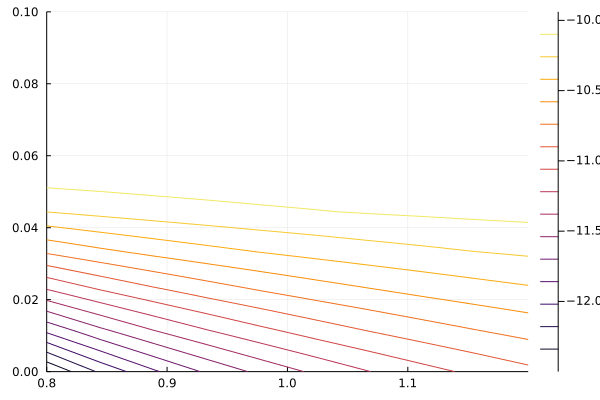

In [159]:
contour(θ_0_vec, θ_1_vec, values)

### Learning to save

__We now focus on the number of steps it takes to optimize $\theta_0$, $\theta_1$.__

__Implement a function `∇(θ::Vector; N=1000)::Vector` which computes the gradient of the objective w.r.t. `θ==[θ_0,θ_1]`. (You need to use automatic differentiation, otherwise you might get incorrect results).__

__Implement a gradient descent algorithm to maximize $\Xi^N(\theta_0, \theta_1)$ using learning rate $\lambda \in ]0,1]$. Stop after a predefined number of iterations. Compare convergence speed for different values of $\lambda$ and plot them on the $\theta_0, \theta_1$ plan. How many steps does it take to enter the `1%` error zone? The `5%` and the `10%` error zone?__

__Even for big N, the evaluated value of ∇ are stochastic, and always slightly inaccurate. In average, they are non-biased and the algorithm converges in expectation (it fluctuates around the maximum). This is called the stochastic gradient method.__

__What are the values of $N$ and $\lambda$ which minimize the number of iterations before reaching the target zones (at 1%, 2%, etc...)? How many simulations periods does it correspond to? Would you say it is realistic that consumers learn from their own experience?__